In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import noisereduce
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
#import torchvision
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from matplotlib import rcParams

d:\Python\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
lab_df = pd.read_csv('Summary_Emo_Eval.csv')

lab_dic = {}
for ind, row in lab_df.iterrows():
    label = row['emotion']
    if label == 'xxx':
        lab_dic[row['wav_filename']] = 'oth' # other
    elif label == 'exc': # excited
        lab_dic[row['wav_filename']] = 'hap' # happy
    else:
        lab_dic[row['wav_filename']] = label

In [3]:
dataset_dir = 'IEMOCAP/'

X = []
Y = []

for session in [1]:#range(1,6)
    wav_sess_dir = dataset_dir + f'Session{session}/sentences/wav/'
    dialog_names = os.listdir(wav_sess_dir)
    for dialog in dialog_names:
        if dialog.startswith('.'):
            continue
        wav_dialog_dir = wav_sess_dir+dialog+'/'
        sentences_names = os.listdir(wav_dialog_dir)
        for sentence in sentences_names:
            if sentence.startswith('.'):
                continue
            if not sentence.endswith('wav'):
                continue
            label = [lab_dic[sentence[:-4]]]
            if not label[0] in ['ang','hap','sad','neu']:
                continue
            wav_sentence_path = wav_dialog_dir+sentence
            waveform, sr = librosa.load(wav_sentence_path, sr=None)
            mfcc = np.mean(librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=40).T, axis=0)
            melspec = librosa.feature.melspectrogram(y=waveform, sr=sr)
            mel = np.mean(melspec.T, axis=0)
            combined = np.hstack((mfcc, mel))
            X.append(combined.tolist())
            Y.append(label)

In [4]:
X_all = np.array(X)
enc = OneHotEncoder()
enc.fit([['ang'],['hap'],['sad'],['neu']])
Y_all = enc.transform(Y).toarray()

Xtrain, Xvaltest, Ytrain, Yvaltest = train_test_split(X_all, Y_all, test_size=0.2, random_state=42, shuffle=True)
Xval, Xtest, Yval, Ytest = train_test_split(Xvaltest, Yvaltest, test_size=0.5, random_state=42, shuffle=True)

Xtrain_c = np.expand_dims(Xtrain, axis=1)
Xval_c = np.expand_dims(Xval, axis=1)
Xtest_c = np.expand_dims(Xtest, axis=1)

In [5]:
class NNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 256, 5, padding=2)
        self.bn1 = nn.BatchNorm1d(256)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(256, 128, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.drop = nn.Dropout(0.1)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(128, 128, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(2)
        self.conv4 = nn.Conv1d(128, 128, 5, padding=2)
        self.conv5 = nn.Conv1d(128, 128, 5, padding=2)
        self.bn4 = nn.BatchNorm1d(128)
        self.conv6 = nn.Conv1d(128, 128, 5, padding=2)
        self.fc = nn.Linear(2688, 4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.softmax(x)
        return x

net = NNModel()

In [6]:
Xtrain_ts  = torch.Tensor(Xtrain_c)
Ytrain_ts  = torch.Tensor(Ytrain)

Xval_ts = torch.Tensor(Xval_c)
Yval_ts = torch.Tensor(Yval)

Xtest_ts = torch.Tensor(Xtest_c)
Ytest_ts = torch.Tensor(Ytest)

batch_size = 4

train_set = torch.utils.data.TensorDataset(Xtrain_ts,Ytrain_ts)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=False,num_workers=2)

val_set = torch.utils.data.TensorDataset(Xval_ts,Yval_ts)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size,shuffle=False,num_workers=2)

test_set = torch.utils.data.TensorDataset(Xtest_ts,Ytest_ts)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False,num_workers=2)

In [7]:
def Tlabels(a):
    L1=[]
    for x in a:
        L1.append(x)
    return L1


def Plabels(b):
    L2=[]
    for x in b:
        L2.append(x)
    return L2

def conf_mat(cm,L1,L2):
    if len(L2)<1:
        return cm
    for i in range(len(L1)):
        if L2[i]==L1[i]:
            cm[L1[i]][L1[i]]=cm[L1[i]][L1[i]]+1
        else:
            cm[L2[i]][L1[i]]=cm[L2[i]][L1[i]]+1
    return cm
            
def cmplot(cm):
    classes = ['ang','hap','sad','neu']
    confusion_matrix = np.array(cm,dtype=np.int)
    proportion=[]
    for i in confusion_matrix:
        for j in i:
            temp=j/(np.sum(i))
            proportion.append(temp)
    pshow=[]
    for i in proportion:
        pt="%.2f%%" % (i * 100)
        pshow.append(pt)
    proportion=np.array(proportion).reshape(4,4)  
    pshow=np.array(pshow).reshape(4,4)
    #print(pshow)
    config = {
        "font.family":'Times New Roman',  
    }
    rcParams.update(config)
    plt.imshow(proportion, interpolation='nearest', cmap=plt.cm.Blues) 
    plt.title('confusion_matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,fontsize=12)
    plt.yticks(tick_marks, classes,fontsize=12)
    
    thresh = confusion_matrix.max() / 2.

    iters = np.reshape([[[i,j] for j in range(4)] for i in range(4)],(confusion_matrix.size,2))
    for i, j in iters:
        if(i==j):
            plt.text(j, i - 0.12, format(confusion_matrix[i, j]), va='center', ha='center', fontsize=12,color='white',weight=5) 
            plt.text(j, i + 0.12, pshow[i, j], va='center', ha='center', fontsize=12,color='white')
        else:
            plt.text(j, i-0.12, format(confusion_matrix[i, j]),va='center',ha='center',fontsize=12)
            plt.text(j, i+0.12, pshow[i, j], va='center', ha='center', fontsize=12)
    
    plt.ylabel('True label',fontsize=16)
    plt.xlabel('Predict label',fontsize=16)
    plt.tight_layout()
    return plt.show()

    

Epoch     1:
Training Loss 0.322; Training Acc 43.318%; Validation Acc 46.296%; Test Acc 55.046%


d:\Python\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
d:\Python\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


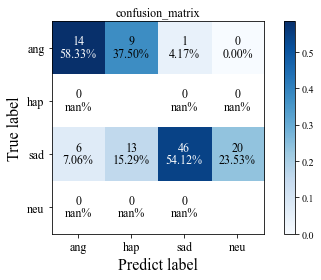

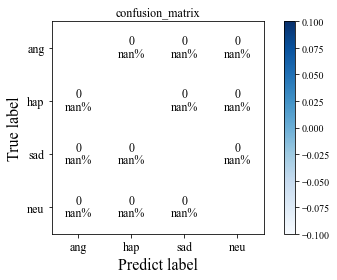

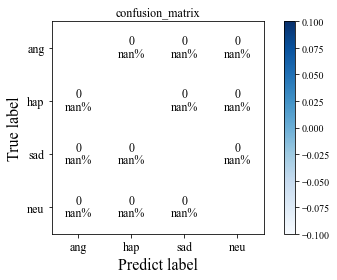

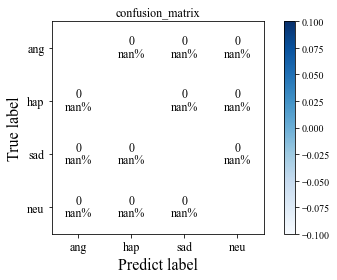

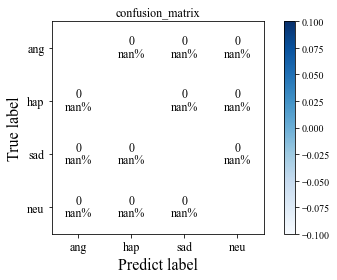

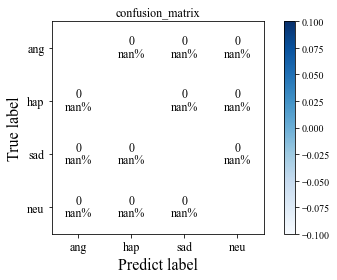

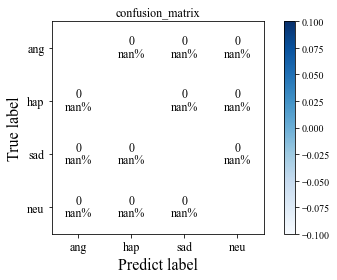

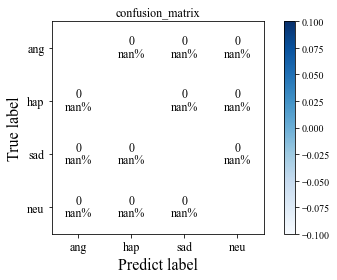

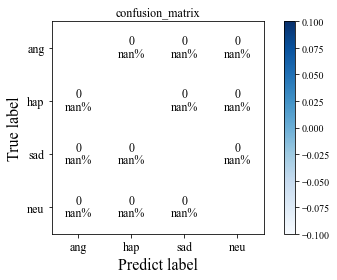

Epoch    10:
Training Loss 0.280; Training Acc 62.673%; Validation Acc 51.852%; Test Acc 64.220%


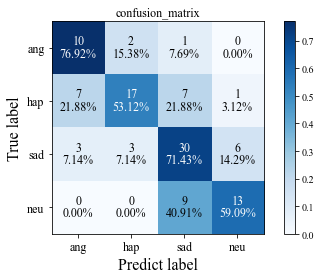

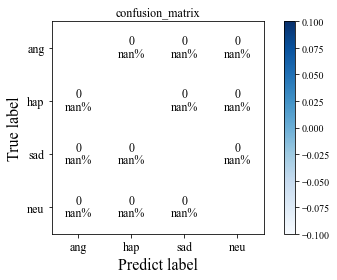

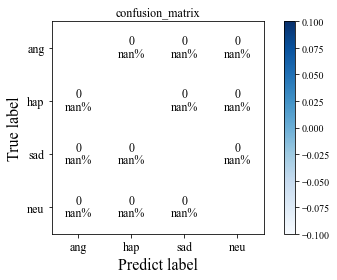

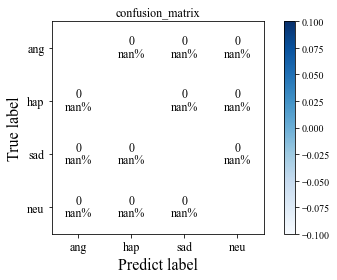

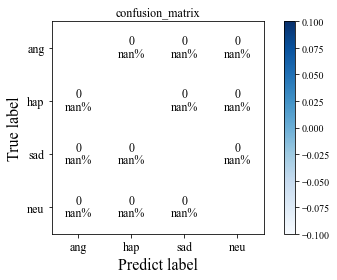

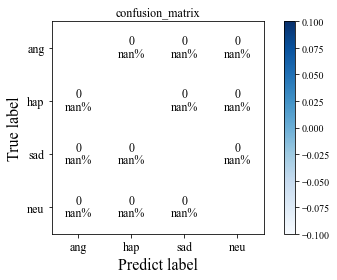

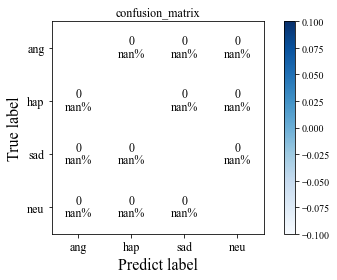

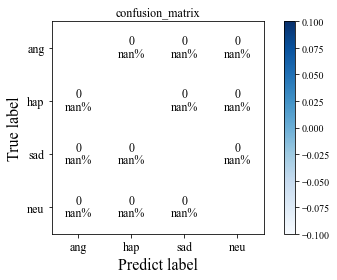

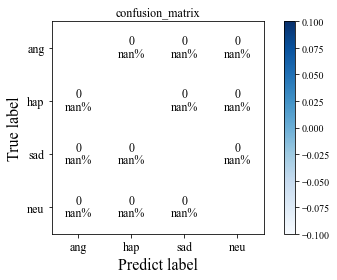

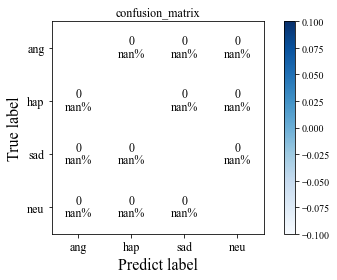

Epoch    20:
Training Loss 0.253; Training Acc 73.157%; Validation Acc 60.185%; Test Acc 65.138%


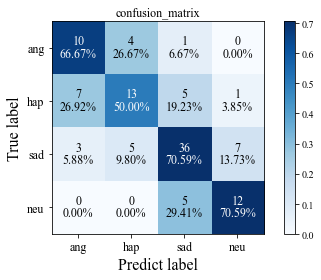

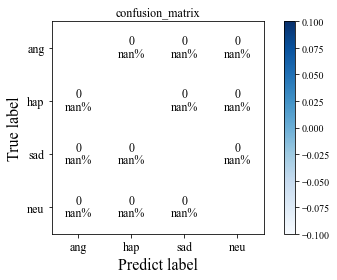

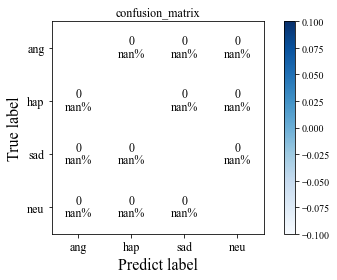

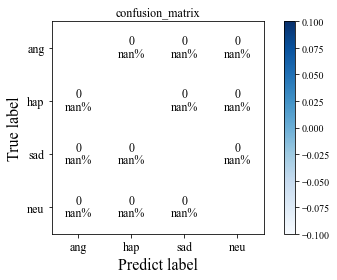

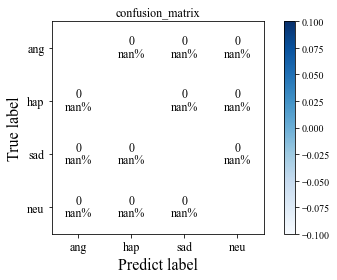

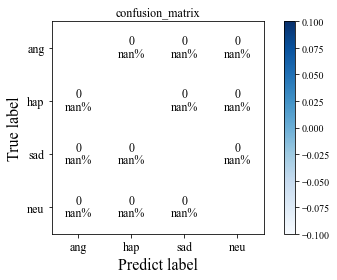

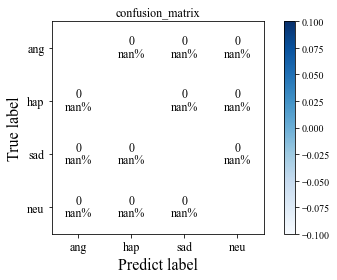

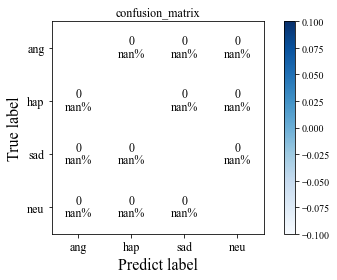

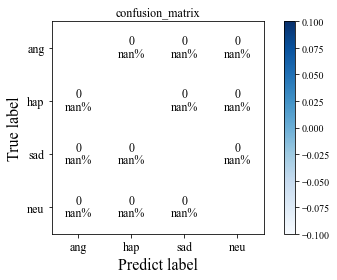

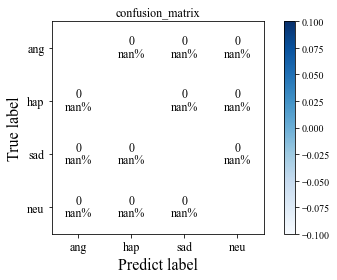

Epoch    30:
Training Loss 0.239; Training Acc 79.147%; Validation Acc 59.259%; Test Acc 66.055%


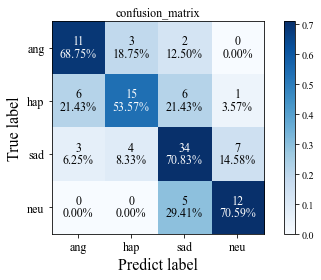

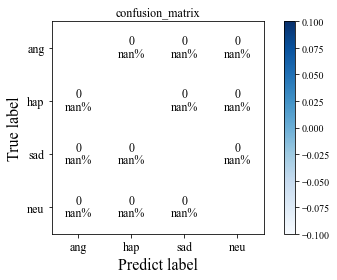

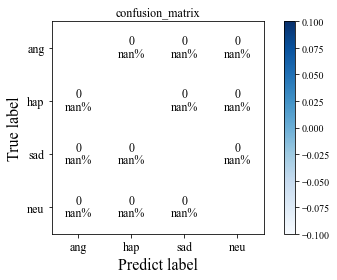

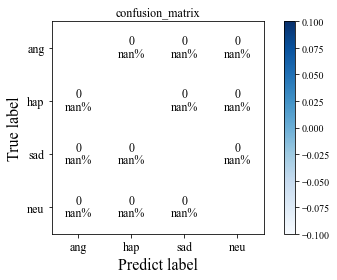

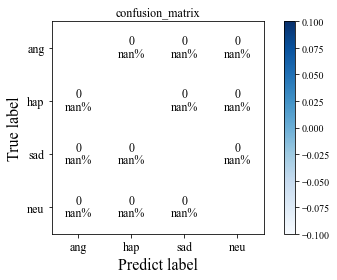

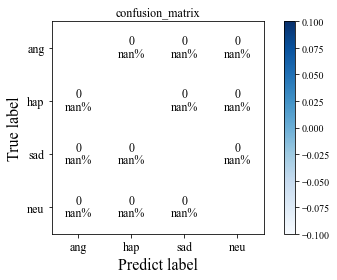

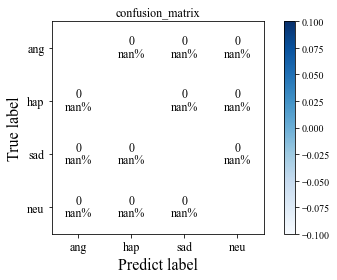

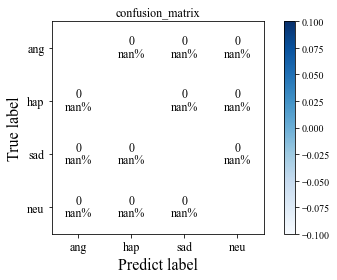

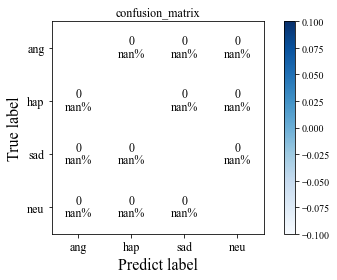

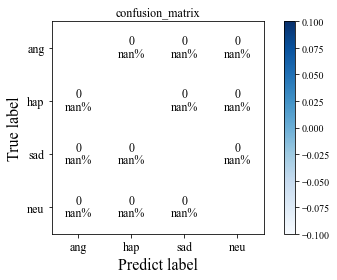

Epoch    40:
Training Loss 0.234; Training Acc 80.991%; Validation Acc 58.333%; Test Acc 63.303%


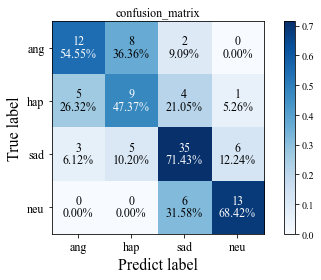

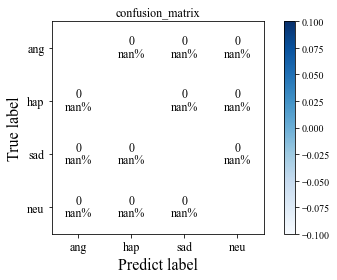

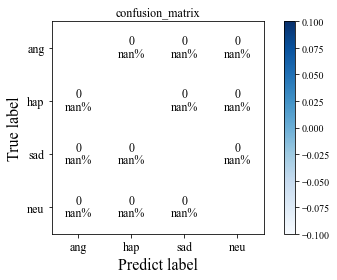

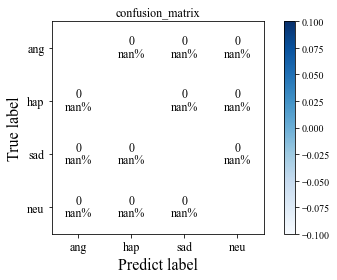

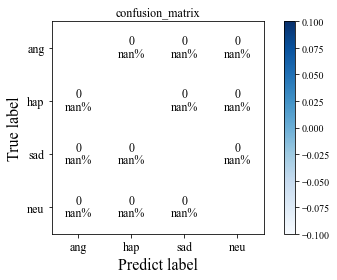

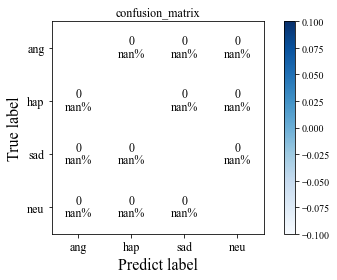

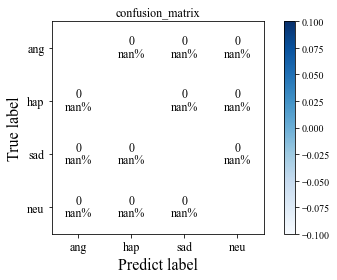

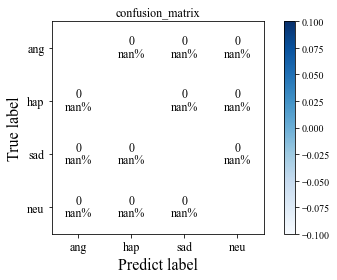

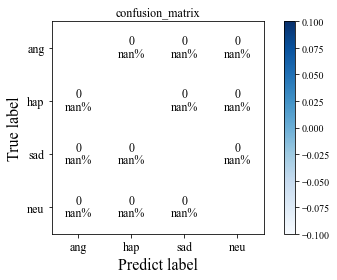

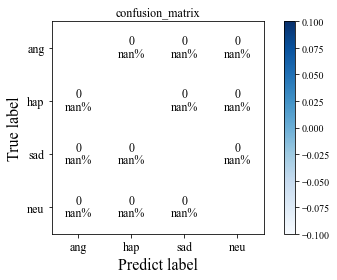

Epoch    50:
Training Loss 0.225; Training Acc 84.447%; Validation Acc 58.333%; Test Acc 61.468%


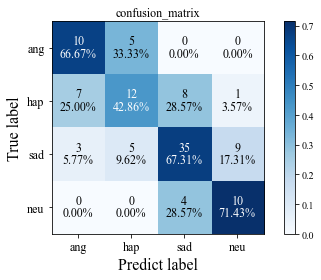

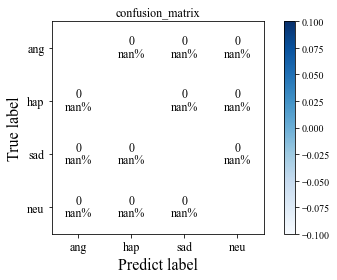

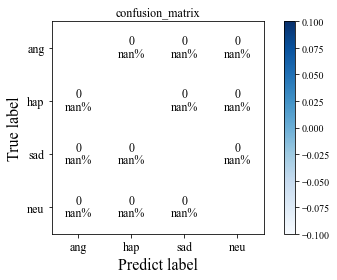

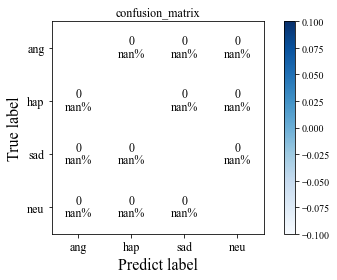

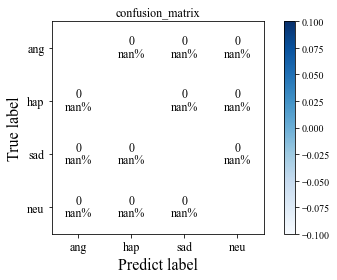

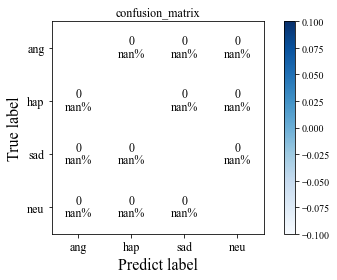

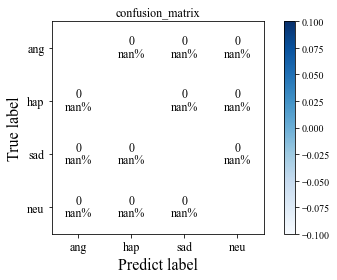

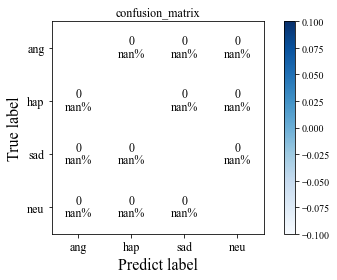

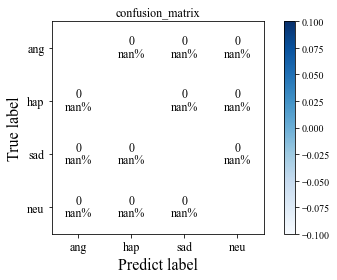

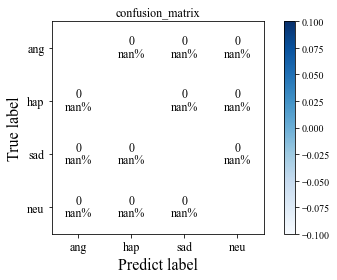

Epoch    60:
Training Loss 0.223; Training Acc 84.908%; Validation Acc 62.037%; Test Acc 69.725%


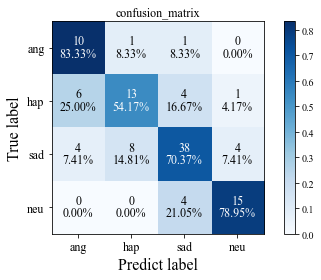

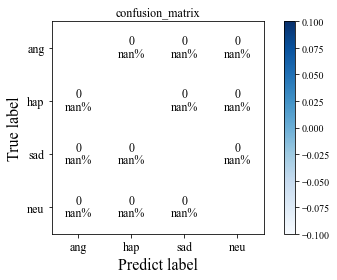

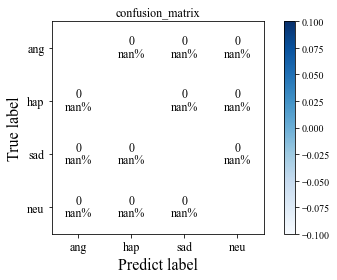

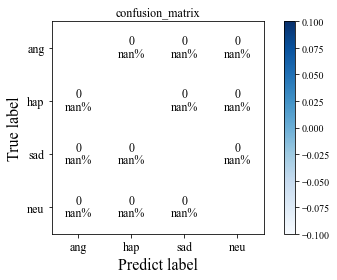

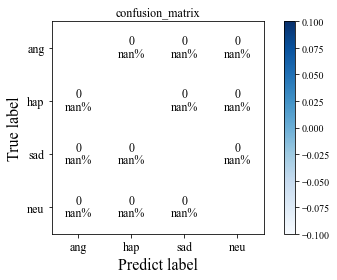

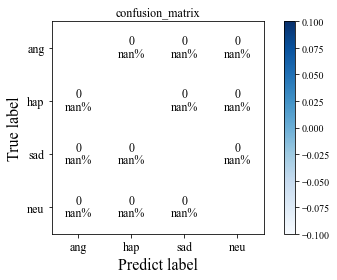

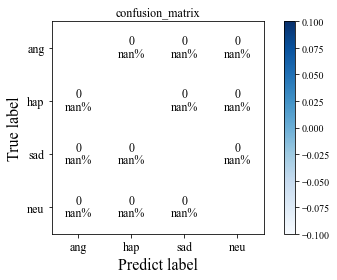

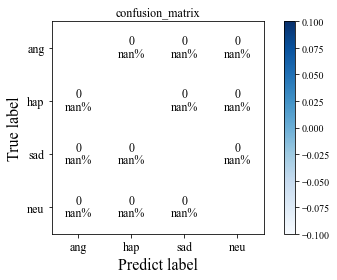

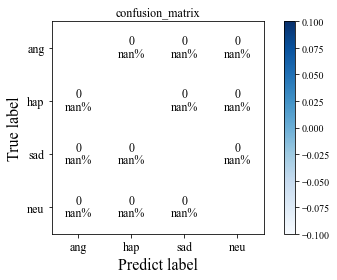

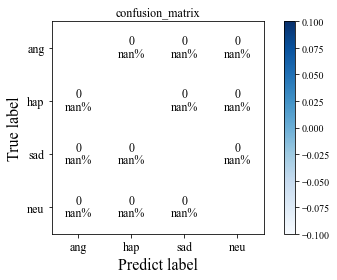

Epoch    70:
Training Loss 0.218; Training Acc 86.866%; Validation Acc 54.630%; Test Acc 63.303%


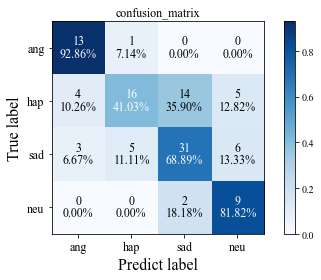

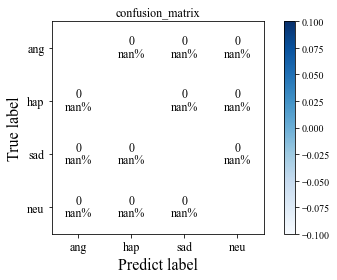

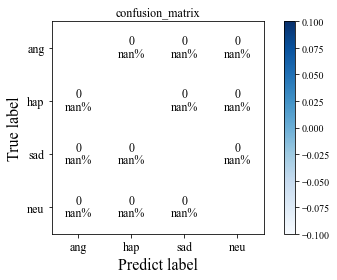

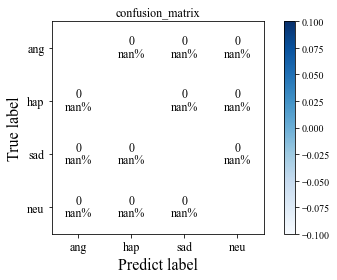

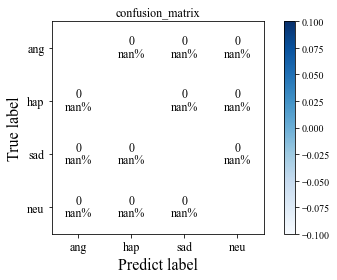

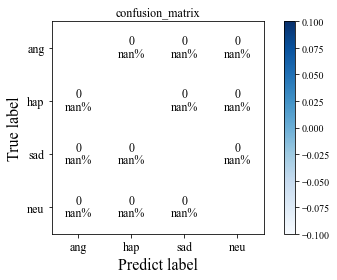

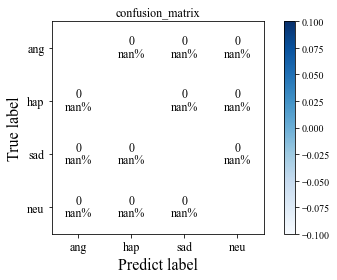

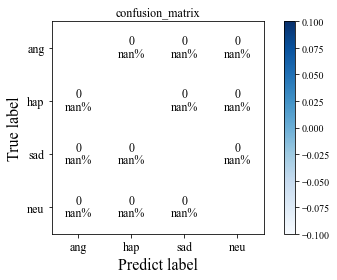

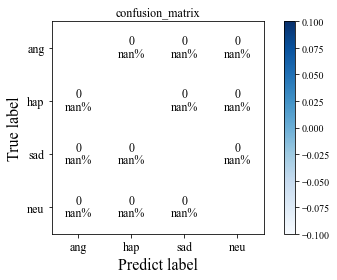

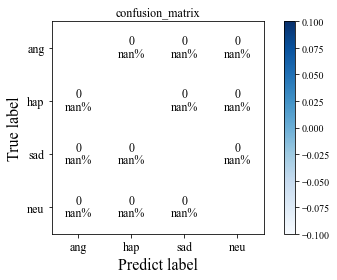

Epoch    80:
Training Loss 0.214; Training Acc 88.825%; Validation Acc 56.481%; Test Acc 61.468%


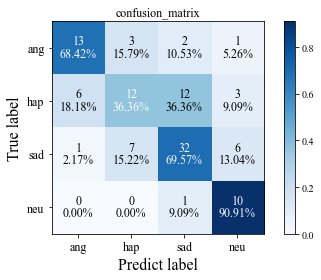

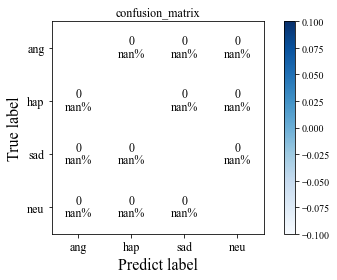

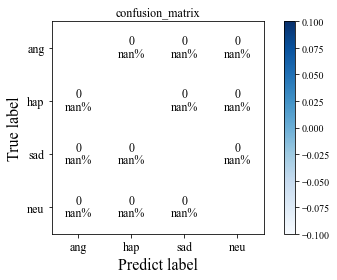

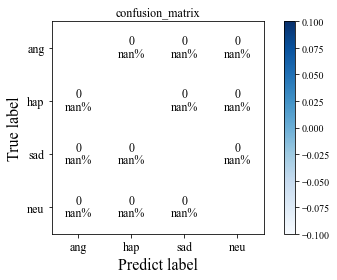

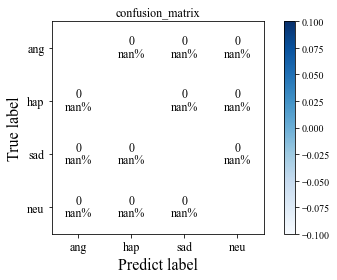

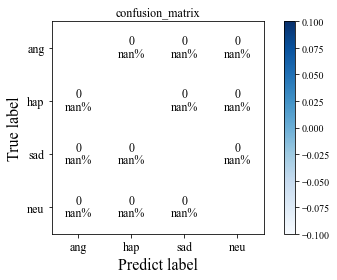

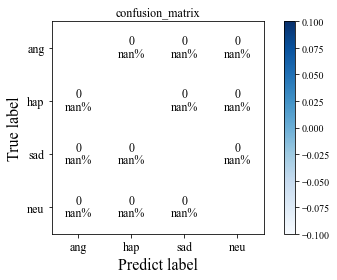

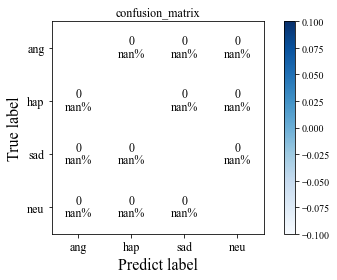

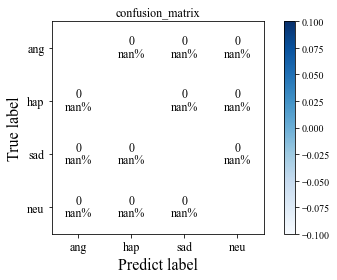

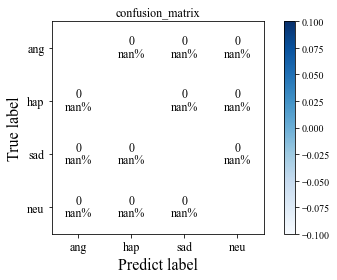

Epoch    90:
Training Loss 0.213; Training Acc 89.286%; Validation Acc 60.185%; Test Acc 67.890%


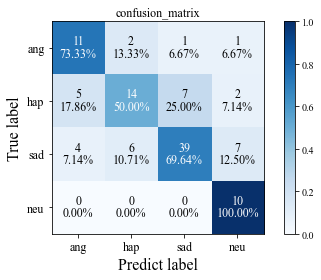

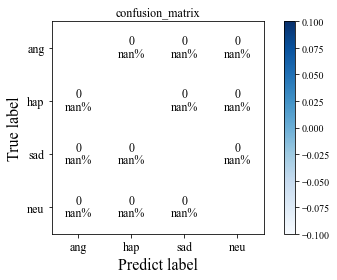

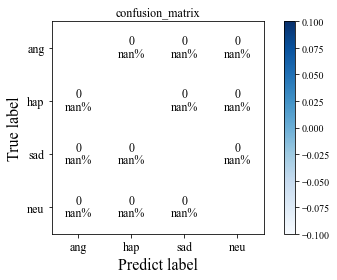

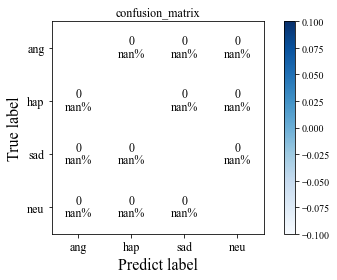

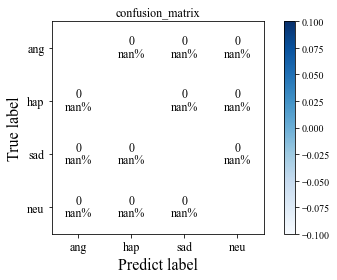

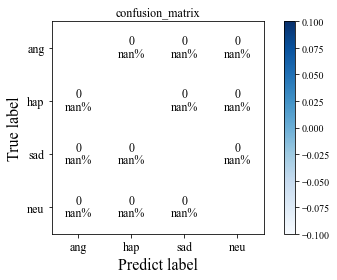

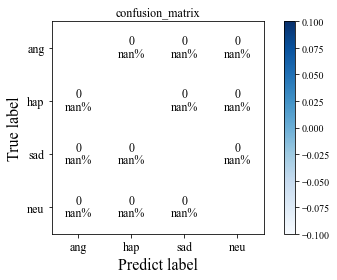

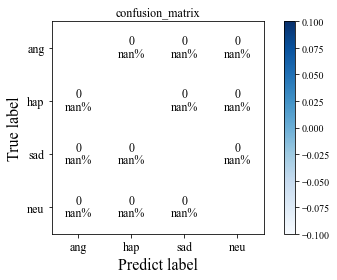

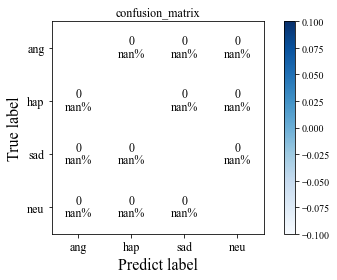

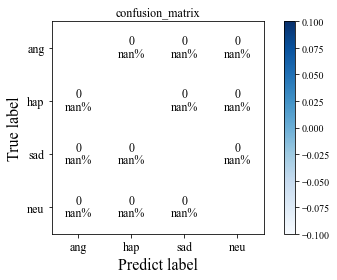

Epoch   100:
Training Loss 0.210; Training Acc 90.323%; Validation Acc 57.407%; Test Acc 66.972%


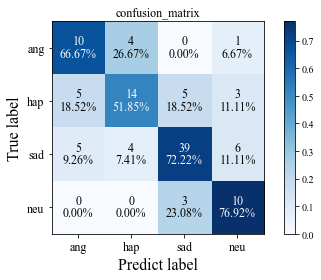

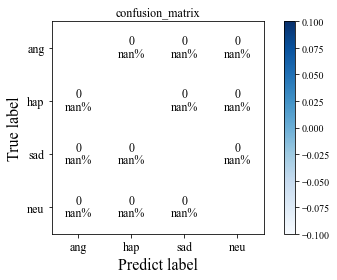

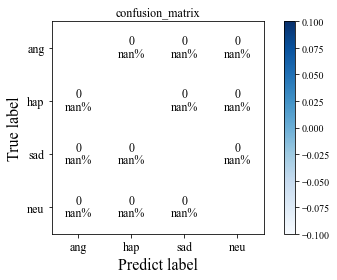

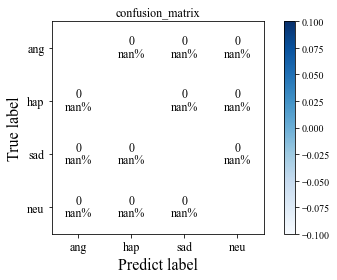

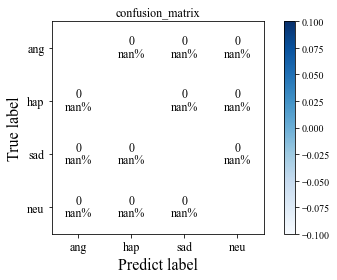

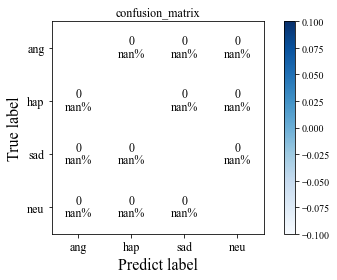

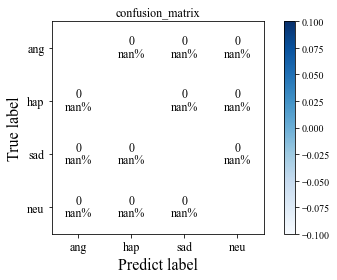

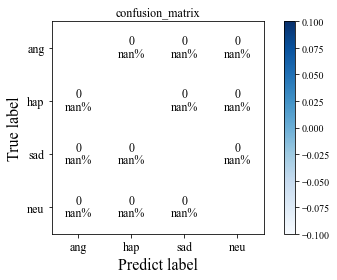

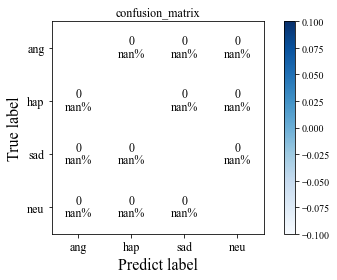

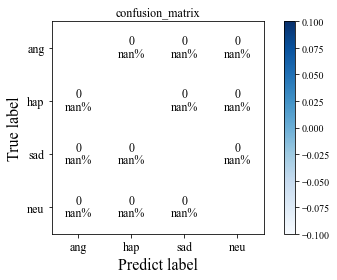

Epoch   110:
Training Loss 0.208; Training Acc 91.129%; Validation Acc 58.333%; Test Acc 55.963%


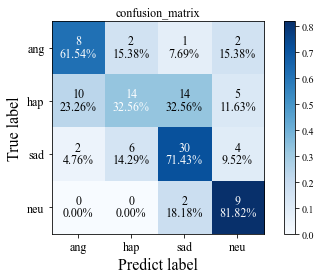

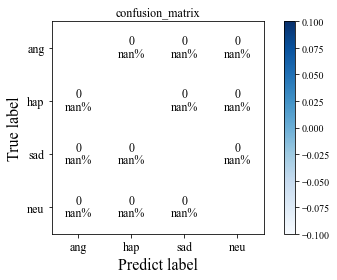

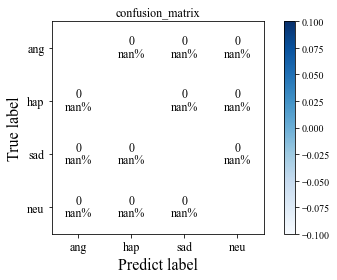

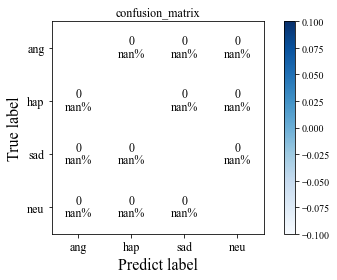

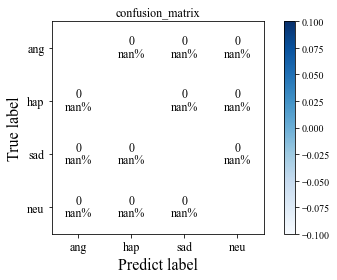

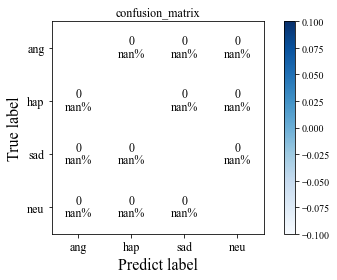

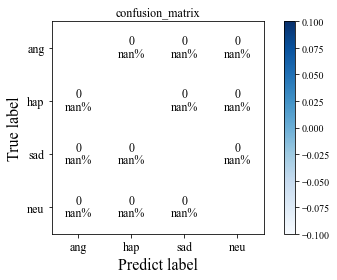

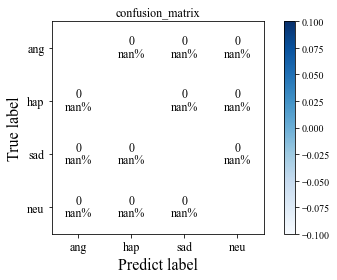

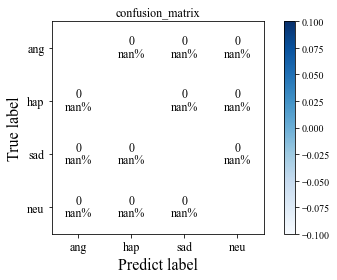

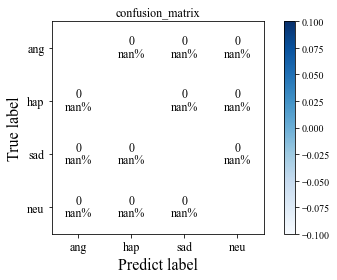

Epoch   120:
Training Loss 0.209; Training Acc 90.553%; Validation Acc 58.333%; Test Acc 65.138%


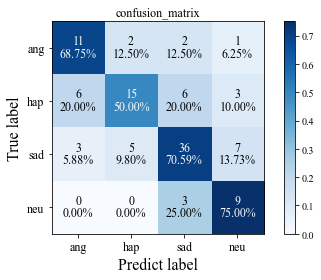

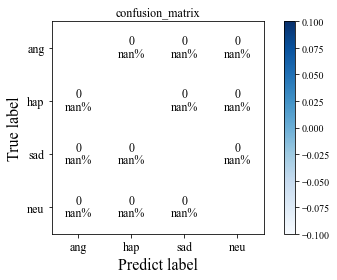

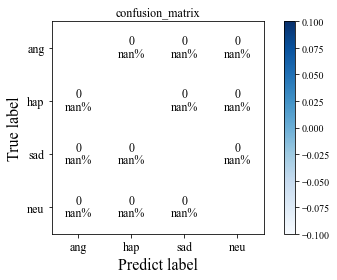

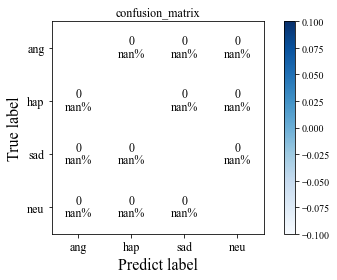

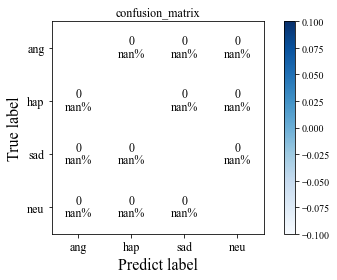

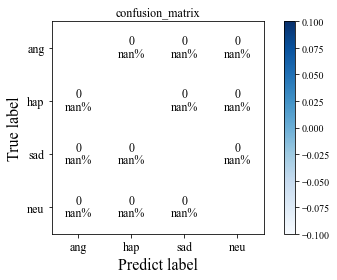

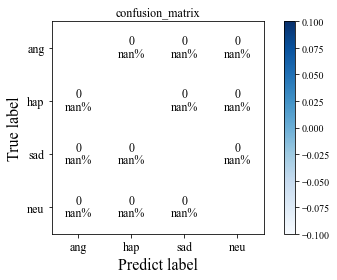

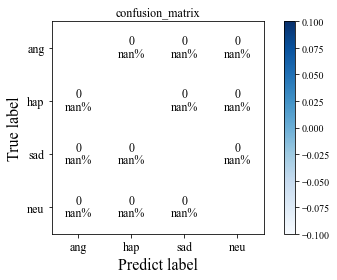

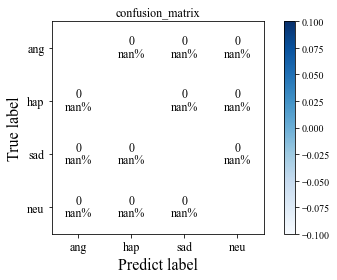

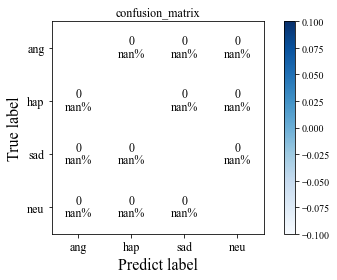

Epoch   130:
Training Loss 0.209; Training Acc 90.899%; Validation Acc 61.111%; Test Acc 61.468%


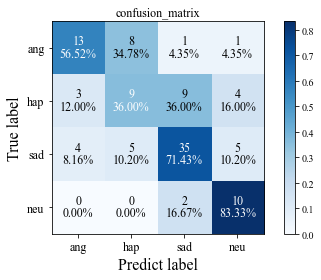

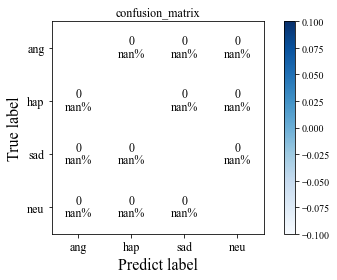

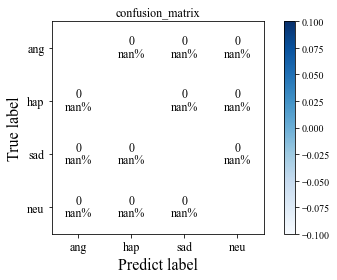

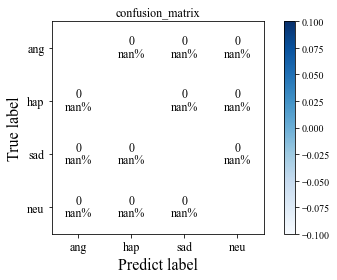

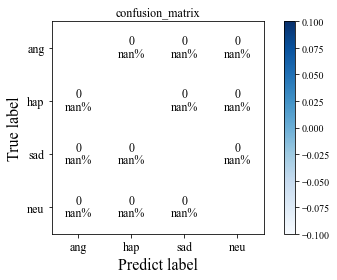

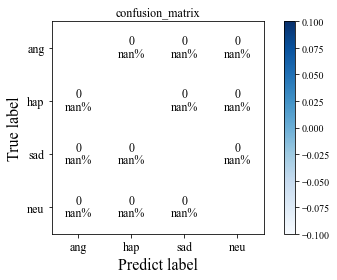

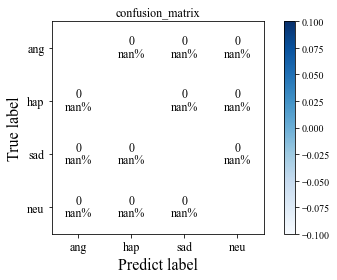

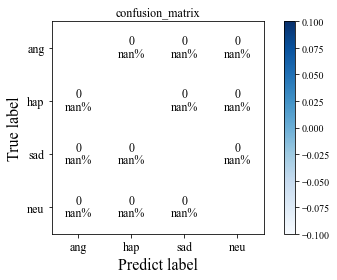

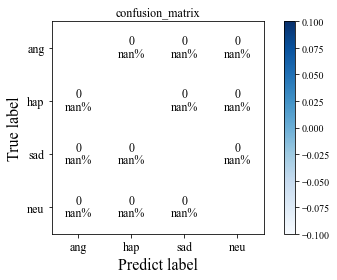

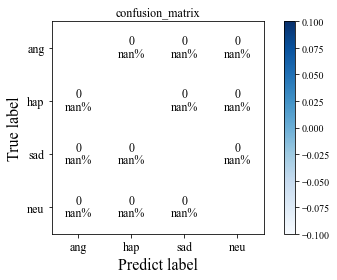

Epoch   140:
Training Loss 0.206; Training Acc 91.705%; Validation Acc 57.407%; Test Acc 63.303%


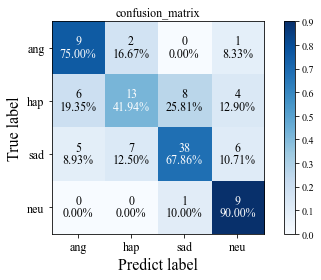

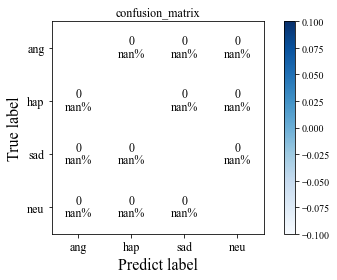

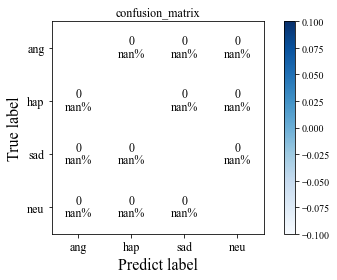

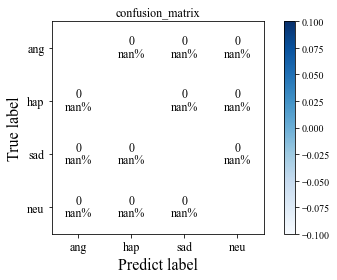

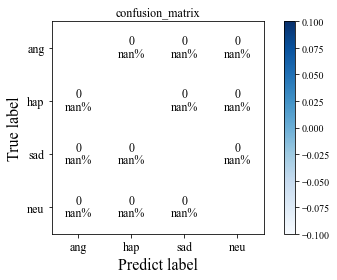

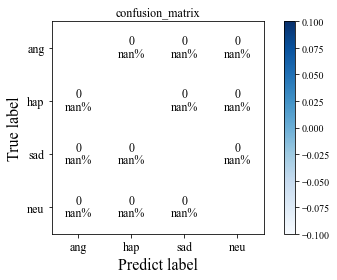

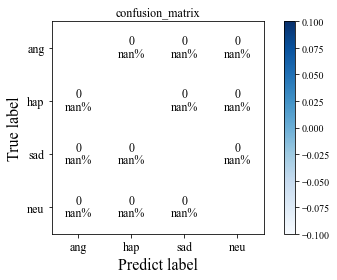

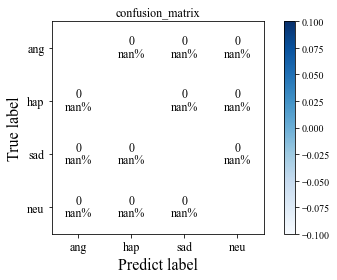

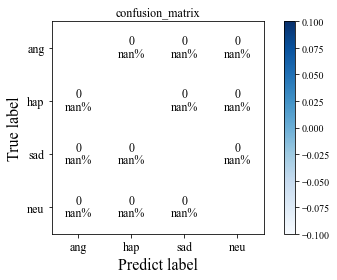

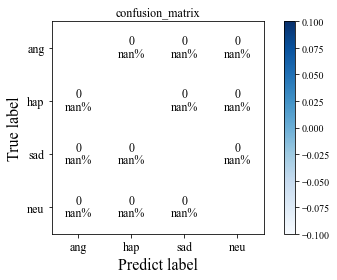

Epoch   150:
Training Loss 0.206; Training Acc 92.051%; Validation Acc 56.481%; Test Acc 65.138%


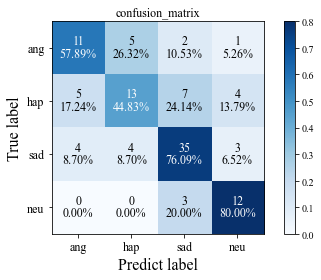

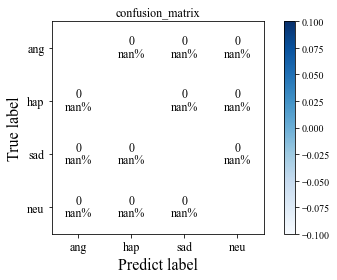

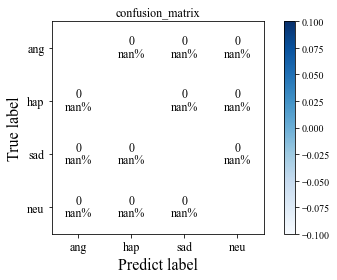

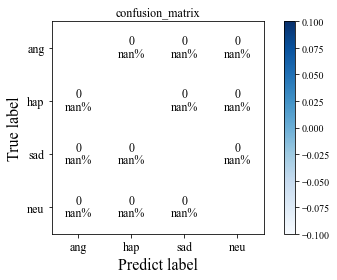

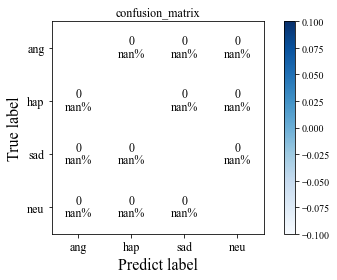

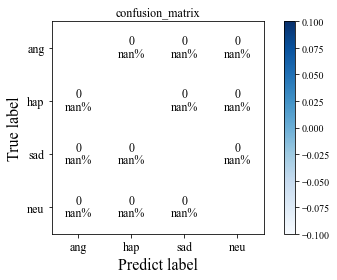

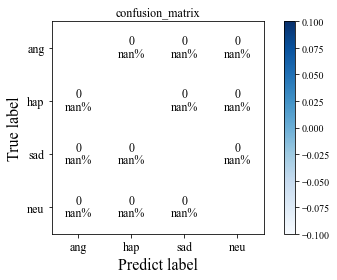

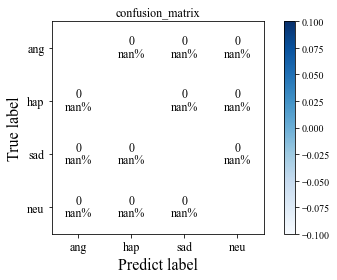

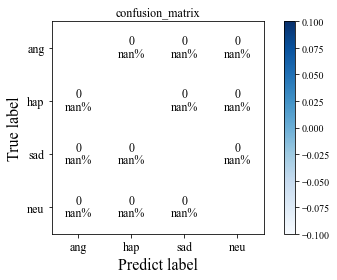

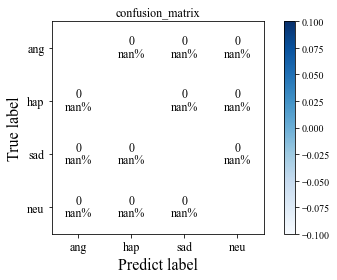

Epoch   160:
Training Loss 0.204; Training Acc 92.396%; Validation Acc 62.037%; Test Acc 66.972%


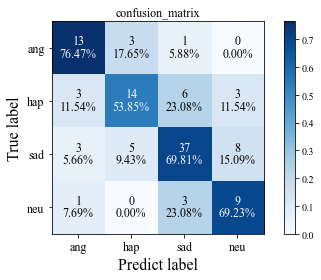

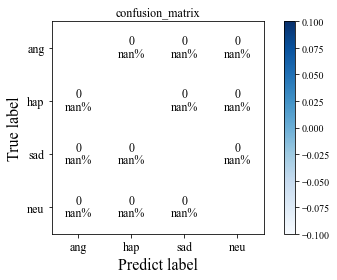

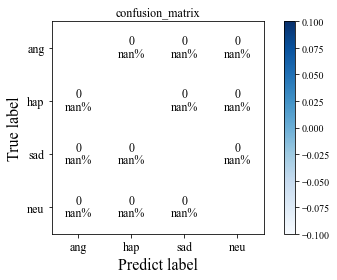

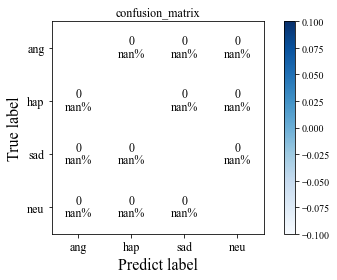

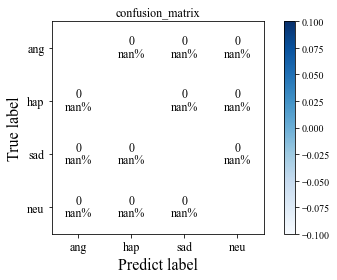

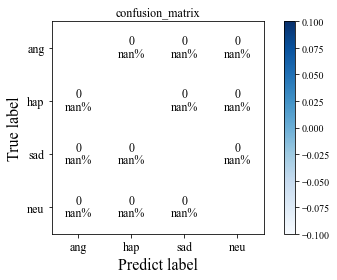

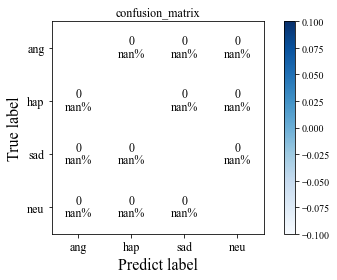

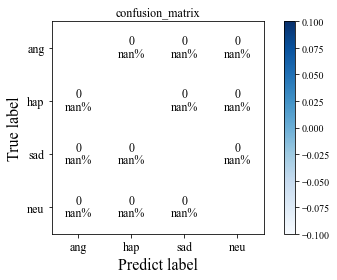

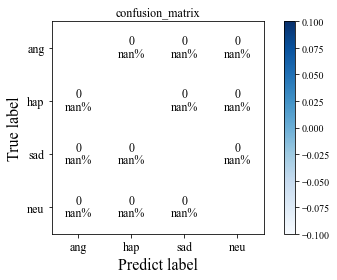

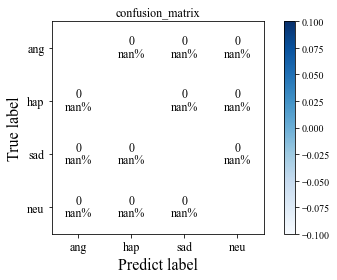

Epoch   170:
Training Loss 0.202; Training Acc 93.433%; Validation Acc 55.556%; Test Acc 66.972%


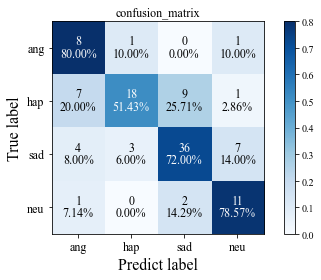

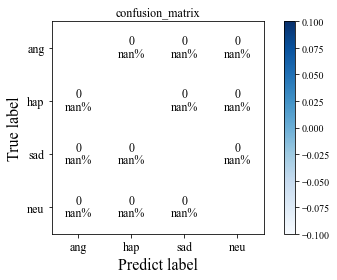

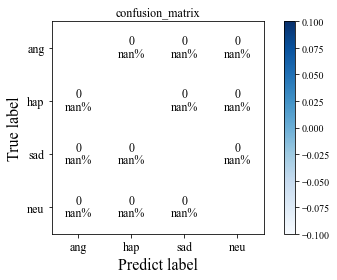

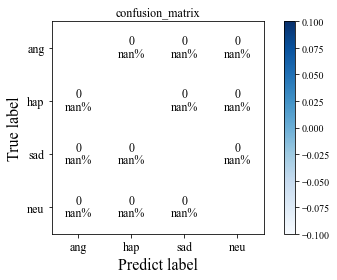

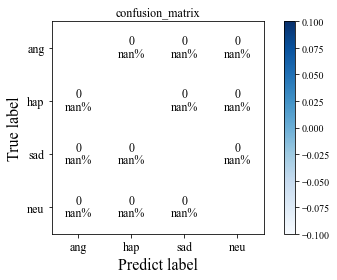

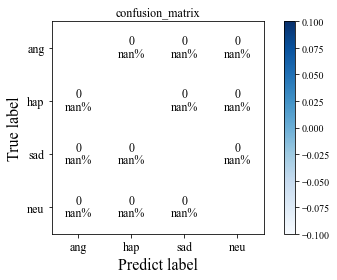

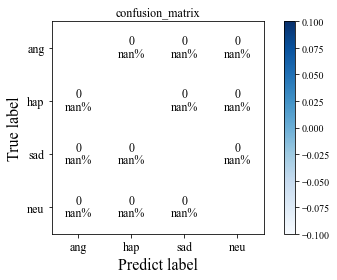

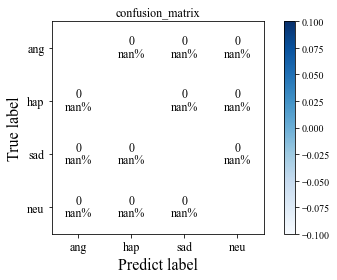

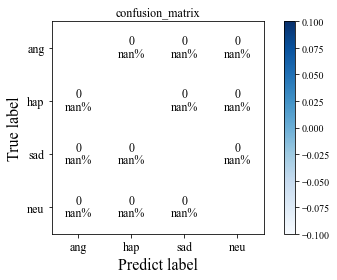

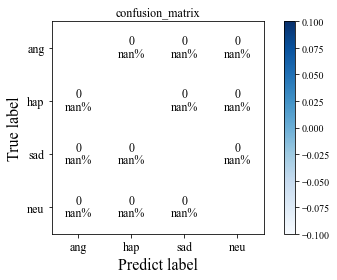

Epoch   180:
Training Loss 0.204; Training Acc 92.742%; Validation Acc 59.259%; Test Acc 68.807%


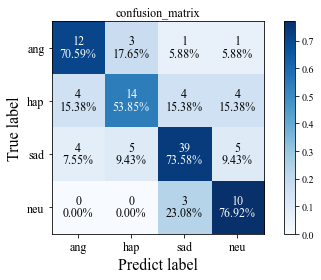

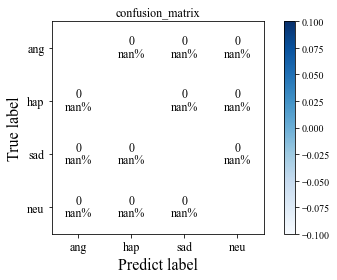

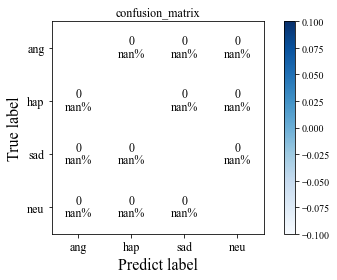

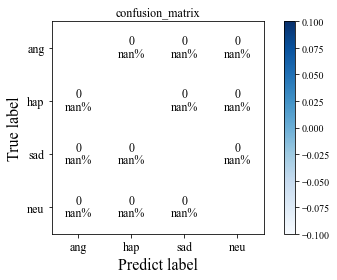

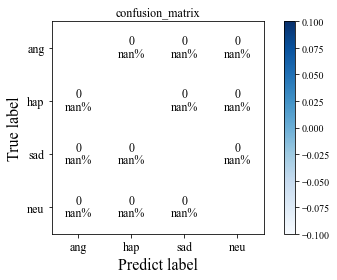

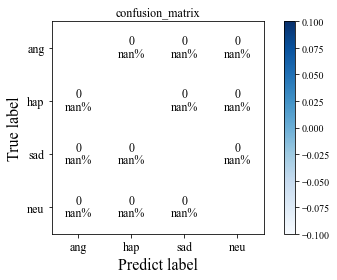

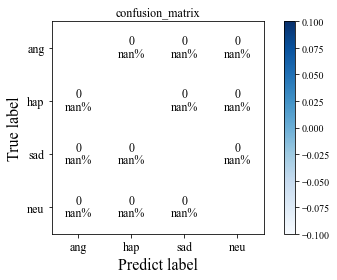

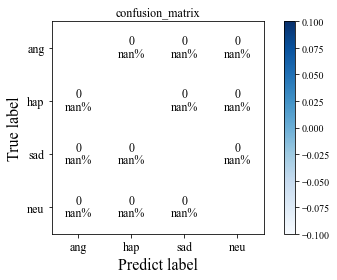

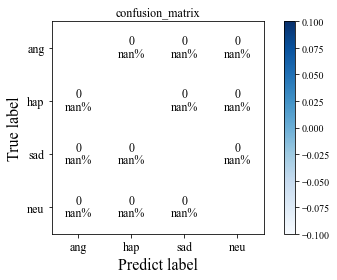

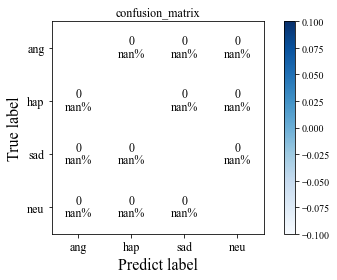

Epoch   190:
Training Loss 0.203; Training Acc 93.548%; Validation Acc 61.111%; Test Acc 71.560%


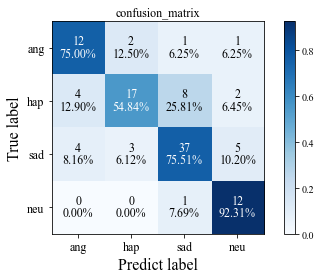

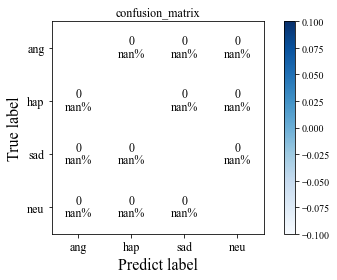

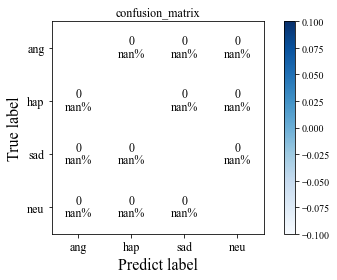

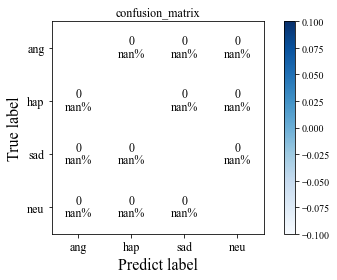

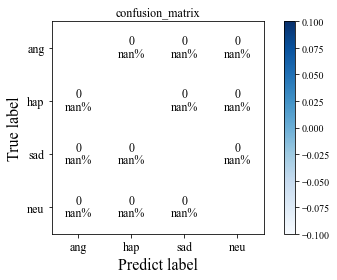

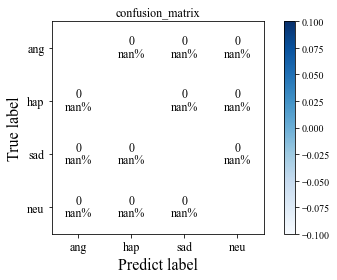

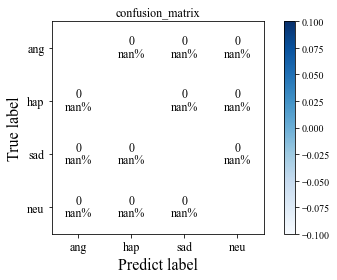

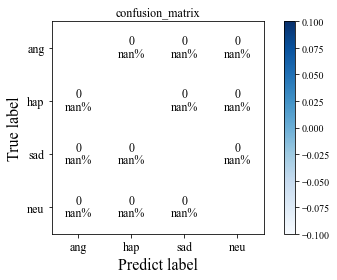

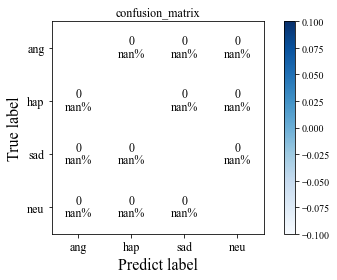

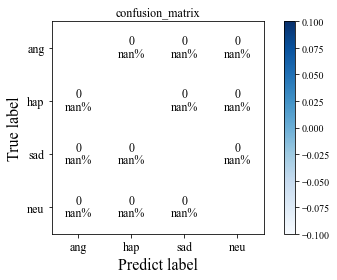

Epoch   200:
Training Loss 0.202; Training Acc 93.433%; Validation Acc 59.259%; Test Acc 67.890%


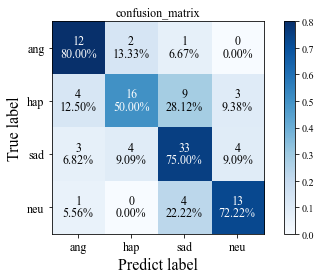

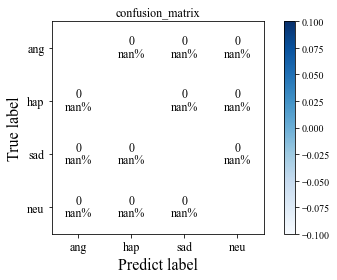

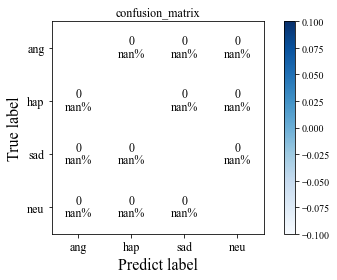

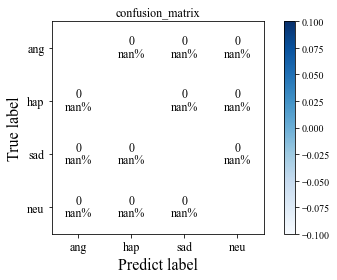

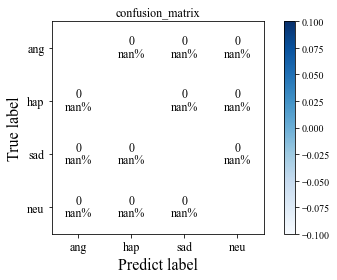

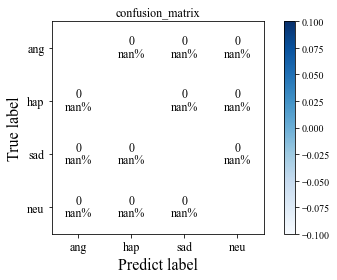

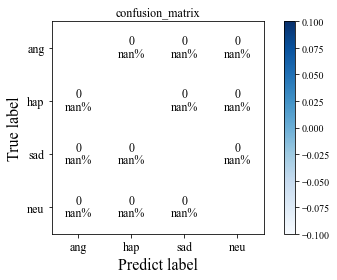

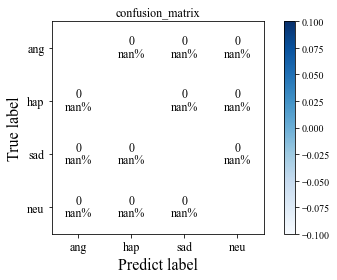

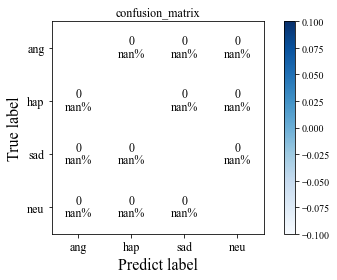

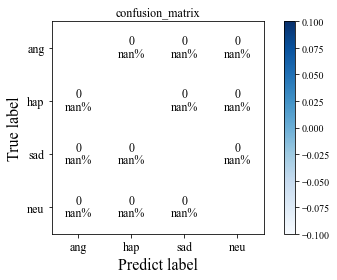

Epoch   210:
Training Loss 0.201; Training Acc 93.894%; Validation Acc 62.037%; Test Acc 59.633%


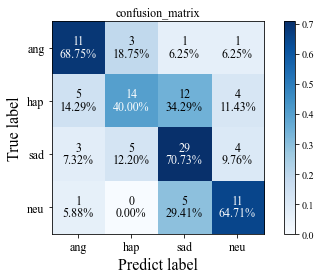

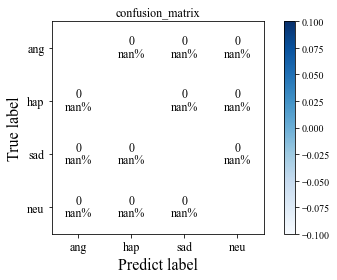

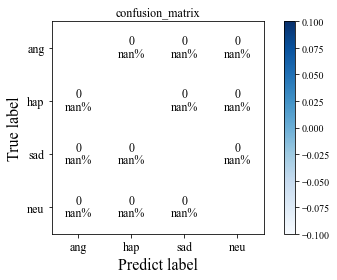

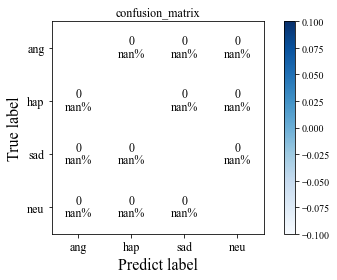

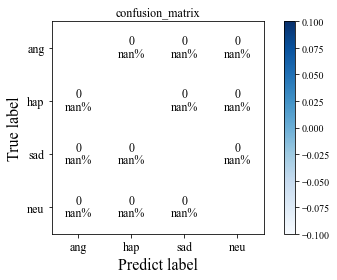

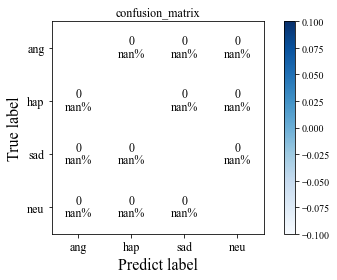

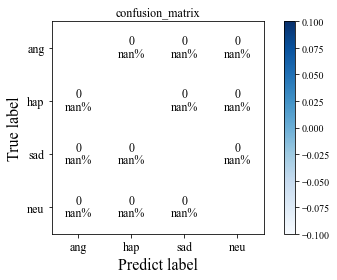

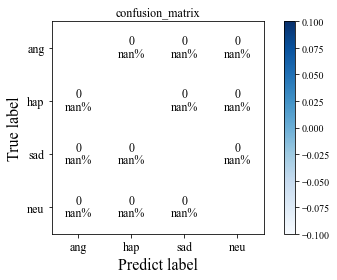

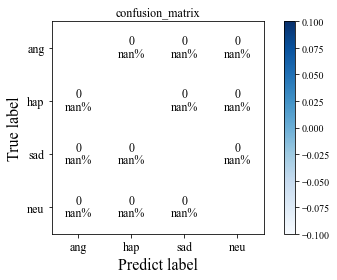

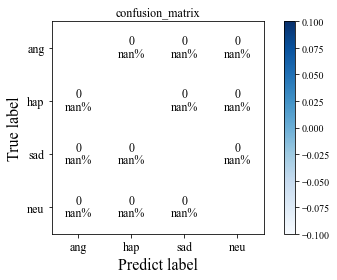

Epoch   220:
Training Loss 0.202; Training Acc 93.548%; Validation Acc 61.111%; Test Acc 58.716%


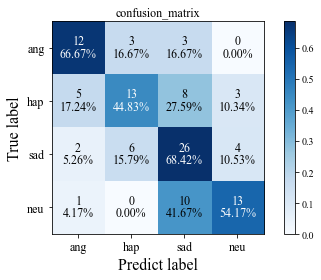

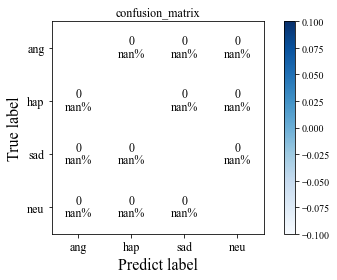

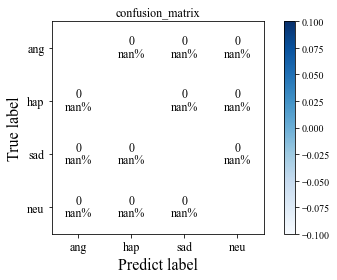

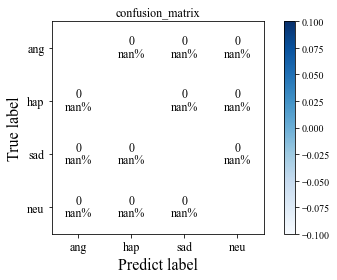

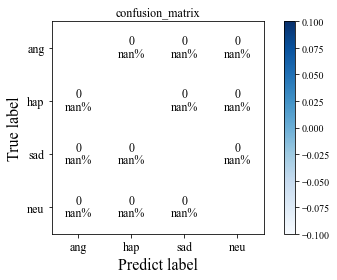

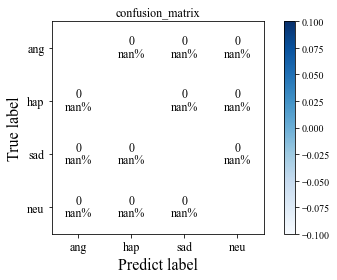

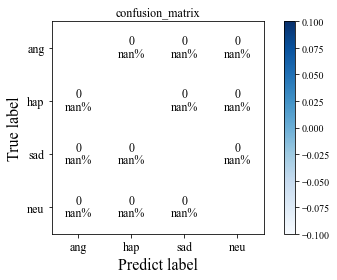

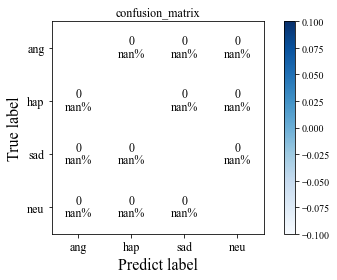

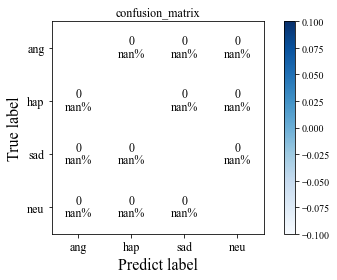

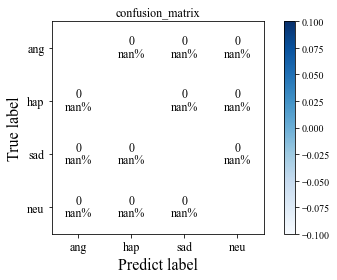

Epoch   230:
Training Loss 0.203; Training Acc 93.088%; Validation Acc 59.259%; Test Acc 67.890%


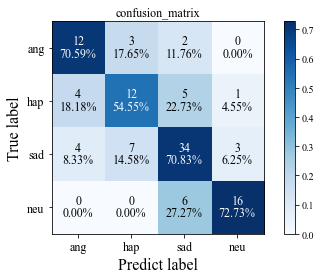

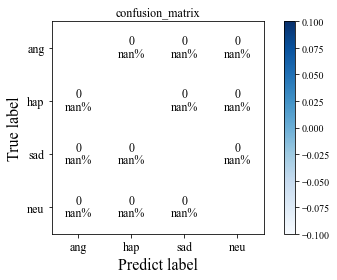

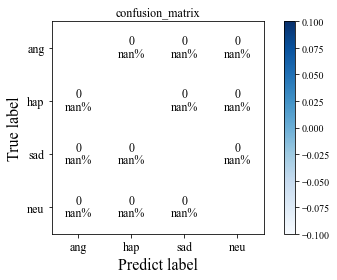

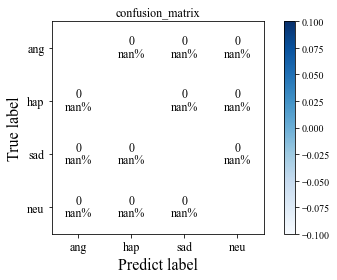

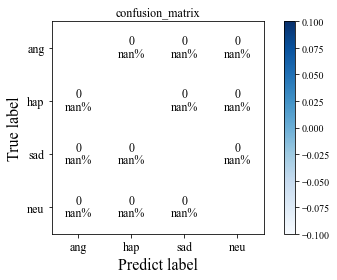

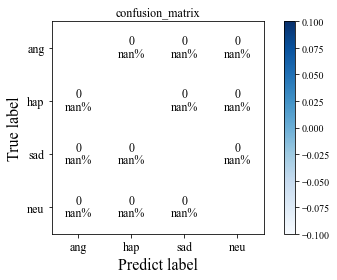

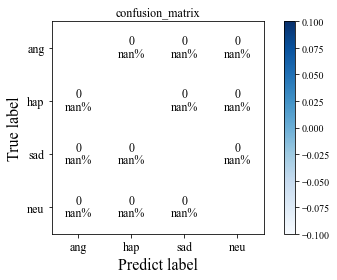

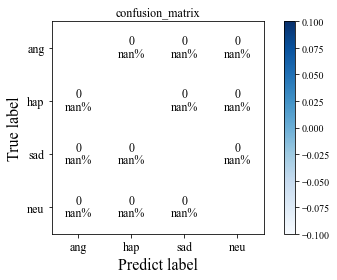

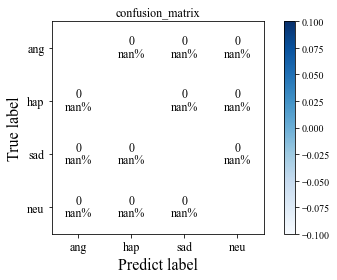

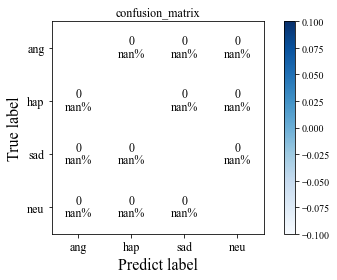

Epoch   240:
Training Loss 0.200; Training Acc 94.355%; Validation Acc 56.481%; Test Acc 54.128%


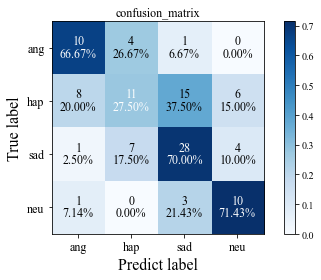

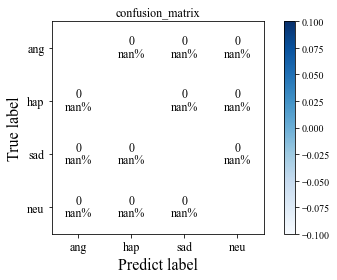

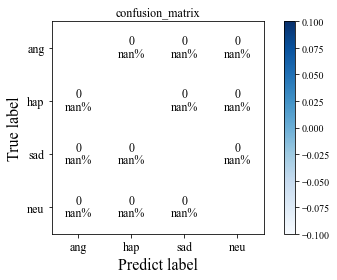

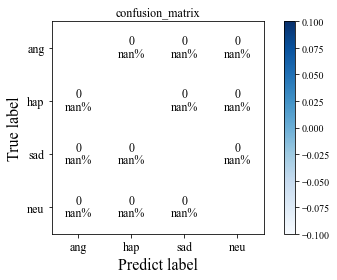

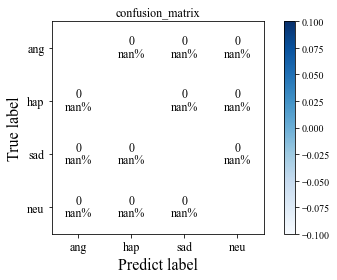

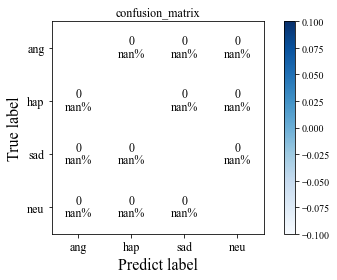

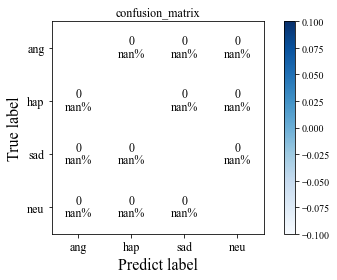

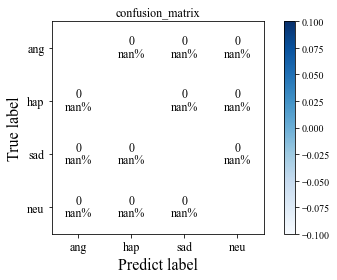

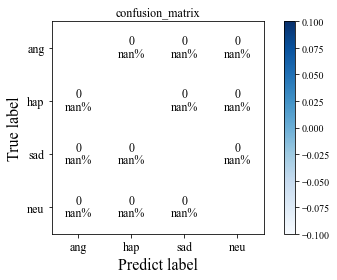

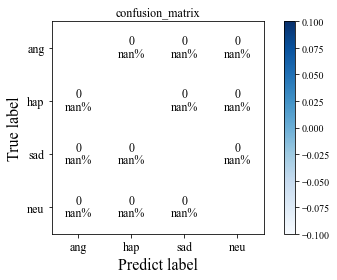

Epoch   250:
Training Loss 0.199; Training Acc 94.700%; Validation Acc 52.778%; Test Acc 61.468%


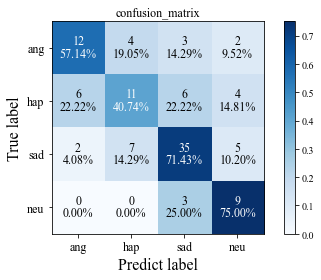

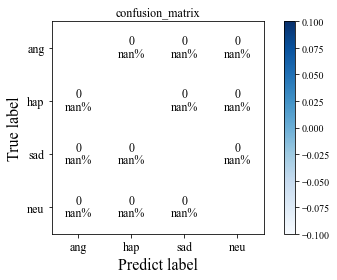

KeyboardInterrupt: 

In [8]:

from matplotlib import transforms

optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.00001)
criterion = nn.CrossEntropyLoss()

epochs = 500

for epoch in range(1, epochs+1):
    cm=[[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    test_acc = 0.0
    for batch, (inputs,targets) in enumerate(train_loader, 0):
        optimizer.zero_grad()
        outputs = net(inputs)
        #print(outputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        preds = torch.max(outputs, 1)[1]
        classes = torch.max(targets, 1)[1]
        #cm=conf_mat(cm,Tlabels(classes.numpy()),Plabels(preds.numpy()))
        train_correct = (preds == classes).sum()
        train_acc += train_correct.item()
        train_loss += loss.item()
    #if epoch:
    if epoch % 10 == 0 or epoch == 1:
        with torch.no_grad():
            net.eval()
            for inputs,targets in val_loader:
                outputs = net(inputs)
                preds = torch.max(outputs, 1)[1]
                classes = torch.max(targets, 1)[1]
                #cm=conf_mat(cm,Tlabels(classes.numpy()),Plabels(preds.numpy()))
                val_correct = (preds == classes).sum()
                val_acc += val_correct.item()
                loss = criterion(outputs, targets)
                val_loss += loss.item()
            for inputs,targets in test_loader:
                outputs = net(inputs)
                preds = torch.max(outputs, 1)[1]
                classes = torch.max(targets, 1)[1]
                cm=conf_mat(cm,Tlabels(classes.numpy()),Plabels(preds.numpy()))
                test_correct = (preds == classes).sum()
                test_acc += test_correct.item()
            net.train()
        Train_loss = train_loss/(len(train_set))
        Train_acc = 100*train_acc/(len(train_set))
        Val_acc = 100*val_acc/(len(val_set))
        Test_acc = 100*test_acc/(len(test_set))
        print(f'Epoch {epoch:5d}:')
        print(f'Training Loss {Train_loss:.3f}; Training Acc {Train_acc:.3f}%; Validation Acc {Val_acc:.3f}%; Test Acc {Test_acc:.3f}%')        
    cmplot(cm)  
print('Finished training')


# after training, choose epoch based on validation accuracy
# to do:
# plot the loss/accuracy
# get confusion matrix
